# Implement Local LGBM Forecasting Model

***

This code implements a local LGBM forecasting model. We use `sktime` to aid in managing the data, plotting, and setting up a forecasting pipeline.

***

Documentation for working with data in `sktime` can be found [here](https://www.sktime.org/en/stable/examples/loading_data.html).

Nested pandas DataFrames are used to store data in `sktime`. Rows correspond to instances, columns correspond to features. The values for each time period for a given feature are nested within a dataframe cell, e.g.:

| index |   dim_0   |    ...    |  dim_c-1  |
|:-----:|:---------:|:---------:|:---------:|
|   0   | pd.Series | pd.Series | pd.Series |
|  ...  | pd.Series | pd.Series | pd.Series |
|   n   | pd.Series | pd.Series | pd.Series |

A `pd.Series` is the one-dimensional data structure for `pandas`.

For univariate series, this structure becomes:

| index |   dim_0   |
|:-----:|:---------:|
|   0   | pd.Series |
|  ...  | pd.Series |
|   n   | pd.Series |

***

## Data Pre-processing for LGBM

Steps from [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0031320321006178):

* Time Series Normalization

$l$ is the length of the $i$th time series, $n$ is the total number of time series, and $\tilde{y}_{i,t}$ is the mean-scaled value of the $t$th time step of the $i$th series.

$$
\tilde{y}_{i,t} = \frac{y_{i,t}}{\frac{1}{l}\sum_{t=1}^{t=l} y_{i,t}}
$$

* Logarithmic Transformation

The above paper has a conditional log-transformation approach for small/zero values. The m4 competition data was adjusted to have no zeroes, so we can just take the log.

* Moving Window Approach

A moving window approach is used for forecasting with the LGBM and NN models.

* Window Normalization

The same normalization process as above is applied on a per-window basis (include window and target value in normalization process).

**We can easily implement the first three. Haven't found an easy way to implement the fourth, not sure we want to get that complex for this paper. I think we are focusing more on 'out-of-the-box' forecasting models.**

***

## Importing and Transforming Data

In [1]:
# import functions for transforming data to work with sktime
from sktime.datatypes._panel._convert import from_2d_array_to_nested, from_nested_to_2d_array, is_nested_dataframe
import pandas as pd
import numpy as np

In [2]:
# import weekly finance time series
Y = pd.read_csv("../../../Data/Train/Clean/weekly_finance_clean.csv")

In [3]:
# store the number of series and number of time periods
num_series, num_periods = Y.shape

In [4]:
Y

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248
0,10825.88,10830.99,10831.68,10826.93,10782.88,10753.11,10708.7,10133.12,10055.67,9976.13,...,10551.34,10536.37,10603.52,10625.25,10665.82,10647.36,10642.22,10678.92,10678.0,10676.48
1,1725.70,1725.70,1749.70,1749.70,1917.60,1917.60,1813.3,1813.30,1991.30,1991.30,...,3538.90,3611.90,3611.90,3680.90,3680.90,3534.20,3534.20,3566.90,3566.9,3489.80
2,733.60,856.20,778.30,763.20,744.50,745.70,681.4,668.70,695.10,729.70,...,1043.80,1081.10,1081.40,1089.10,984.80,1048.60,1059.60,1113.30,1016.8,1084.10
3,733.60,856.20,778.30,763.20,744.50,745.70,681.4,668.70,695.10,729.70,...,1043.80,1081.10,1081.40,1089.10,984.80,1048.60,1059.60,1113.30,1016.8,1084.10
4,2166.00,2126.00,2100.00,2026.00,2028.00,2015.00,2013.0,1983.00,2019.00,2036.00,...,2536.00,2534.00,2554.00,2567.00,2548.00,2512.00,2542.00,2606.00,2607.0,2530.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,1092.00,1085.00,1078.00,1092.00,1085.00,1078.00,1092.0,1086.00,1078.00,1091.00,...,1093.00,1085.00,1078.00,1071.00,1064.00,1092.00,1085.00,1078.00,1071.0,1064.00
160,1820.00,1813.00,1806.00,1799.00,1792.00,1820.00,1813.0,1806.00,1799.00,1820.00,...,1799.00,1792.00,1785.00,1820.00,1813.00,1806.00,1799.00,1792.00,1785.0,1778.00
161,1917.90,1918.30,1947.70,1954.50,2022.70,2008.30,1996.6,1984.30,1978.80,1980.40,...,2578.70,2588.40,2573.90,2579.90,2564.10,2584.90,2503.20,2378.30,2381.2,2509.40
162,1368.00,1305.50,1308.60,1280.20,1356.30,1217.90,1432.5,1256.30,1363.80,1480.10,...,2232.70,2278.50,2255.70,2166.70,2127.70,2112.70,2102.90,2102.20,2177.5,2160.30


We apply the time series normalization and log transformation prior to all modeling.

In [5]:
series_means = np.mean(Y, axis=1)

In [6]:
series_means

0      10341.264008
1       2844.380567
2        866.254251
3        866.254251
4       2293.910931
           ...     
159     1079.425101
160     1804.234818
161     2179.557490
162     1738.462753
163     6338.291498
Length: 164, dtype: float64

In [7]:
# time series normalization
Y_norm = Y.divide(series_means, axis="index")

In [8]:
# log transformation
Y_norm_log = np.log(Y_norm)

In [9]:
# transform to nested dataframe structure
Y_nested = from_2d_array_to_nested(Y_norm_log)

In [10]:
# test for nested dataframe structure
is_nested_dataframe(Y_nested)

True

In [11]:
Y_nested.iloc[0,0]

0      0.045797
1      0.046269
2      0.046333
3      0.045894
4      0.041818
         ...   
242    0.029170
243    0.028687
244    0.032130
245    0.032043
246    0.031901
Length: 247, dtype: float64

***

## Forecast with Local LGBM for One Series

An LGBM can only predict based on a window of data. 

Generating forecasts using an LGBM can be done using multiple strategies. 

One common strategy is 'recursive', where input data window is rolled forward as forecasts are generated. Depending on the forecast horizon and the window length, this means forecasts could be made using entirely forecasted data. Recursive strategies suffer from error accumulation.

A second strategy is 'direct', where a model is trained to predict a single value $h$ steps ahead given the training data. To make forecasts for the full horizon, one model is trained for each time period in the horizon. More computationally complex, but can reduce error. Ignores the dependencies between forecasted values (more complicated strategies can account for this).

First, train a local LGBM model (trained on data from one series) for one series only using 'recursive' strategy.

In [12]:
# general modules
import pandas as pd
import numpy as np

# light gradient boosting model package
import lightgbm as lgb

#### sktime functions ####

# train-test split function for temporal data
from sktime.forecasting.model_selection import temporal_train_test_split

# import trend forecaster to detrend data
from sktime.forecasting.trend import PolynomialTrendForecaster

# import detrender and deseasonalizer
from sktime.transformations.series.detrend import Detrender, Deseasonalizer, ConditionalDeseasonalizer

# data reduction for regressions or trees
from sktime.forecasting.compose import make_reduction

# import composite forecasting tool
from sktime.forecasting.compose import TransformedTargetForecaster

# import mean absolute error and mean squared error metrics (specify square root in function)
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error

# nice time series plots
from sktime.utils.plotting import plot_series

In [13]:
# forecast 20 periods out
fh = np.arange(1, 21)

Scikit-learn API for regression using lgbm [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor).

In [14]:
# this function has tons of options to mess with, we use defaults here
regressor = lgb.LGBMRegressor()

In [15]:
#### forecasting pipeline
# deseasonalize the data
# detrend the data
# ------- need to make these conditional transformations

forecaster = TransformedTargetForecaster(
    [
        #("deseasonalize", Deseasonalizer(sp=52, model="additive")),
        #("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=10, strategy="recursive")),
    ]
)

In [16]:
# select one series
y = Y_nested.iloc[3,0]
y

0     -0.166215
1     -0.011674
2     -0.107066
3     -0.126658
4     -0.151466
         ...   
242    0.191033
243    0.201468
244    0.250905
245    0.160237
246    0.224327
Length: 247, dtype: float64

In [17]:
# train - test split
y_train, y_test = temporal_train_test_split(y, test_size=len(fh))

In [18]:
# train the forecasting model
forecaster.fit(y_train)

TransformedTargetForecaster(steps=[('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=LGBMRegressor()))])

In [19]:
# generate forecasts
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

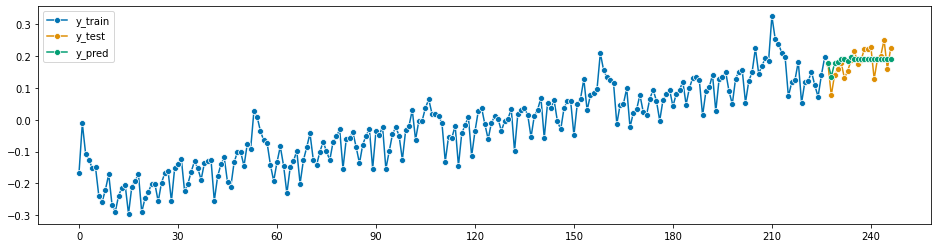

In [20]:
# plot training and testing data and forecasts (y_pred)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [21]:
# # perform post-processing
# y_train = np.exp(y_train)
# y_test = np.exp(y_test)
# y_pred = np.exp(y_pred)

In [22]:
# y_train = y_train*series_means[3]
# y_test = y_test*series_means[3]
# y_pred = y_pred*series_means[3]

In [23]:
# MAE
mean_absolute_error(y_test, y_pred)

0.02877545038154592

In [24]:
# RMSE
mean_squared_error(y_test, y_pred, square_root=True)

0.03457850559237153

***

Train local LGBM models for one series only using 'direct' strategy.

In [25]:
# select one series
y = Y_nested.iloc[3,0]
# train - test split
y_train, y_test = temporal_train_test_split(y, test_size=len(fh))

In [26]:
#### forecasting pipeline
# deseasonalize the data
# detrend the data
# ------- need to make these conditional transformations

forecaster = TransformedTargetForecaster(
    [
        #("deseasonalize", Deseasonalizer(sp=52, model="additive")),
        #("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=10, strategy="direct")),
    ]
)

In [27]:
h = 20
y_preds = []

for i in range(h):
    
    forecaster.fit(y_train, fh=i+1)
    
    y_preds.append(forecaster.predict())

In [28]:
y_preds = pd.concat(y_preds)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

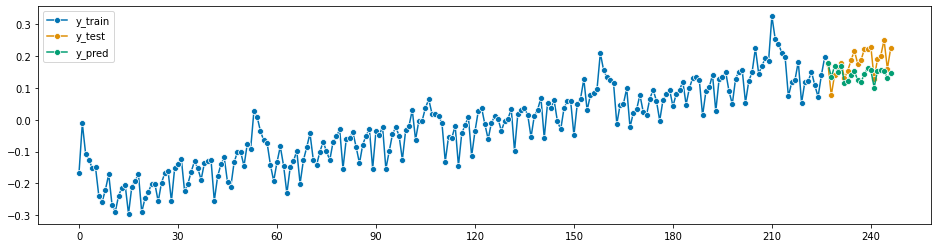

In [29]:
# plot training and testing data and forecasts (y_pred)
plot_series(y_train, y_test, y_preds, labels=["y_train", "y_test", "y_pred"])

In [30]:
# # perform post-processing
# y_train = np.exp(y_train)
# y_test = np.exp(y_test)
# y_preds = np.exp(y_preds)

In [31]:
# y_train = y_train*series_means[3]
# y_test = y_test*series_means[3]
# y_preds = y_preds*series_means[3]

In [32]:
# MAE
mean_absolute_error(y_test, y_preds)

0.04517281288603069

In [33]:
# RMSE
mean_squared_error(y_test, y_preds, square_root=True)

0.052199701937784164

***

## Forecast with Local LGBM for All Series

Use 'recursive' approach first.

In [34]:
#### forecasting pipeline
# deseasonalize the data
# detrend the data
# ------- need to make these conditional transformations

forecaster = TransformedTargetForecaster(
    [
        #("deseasonalize", Deseasonalizer(sp=52, model="additive")),
        #("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=10, strategy="recursive")),
    ]
)

In [35]:
# empty arrays to store error metrics for each series
maes = np.zeros([num_series])
rmses = np.zeros([num_series])
# list to store forecasts
Y_preds = []

# loop over all series
for i in range(num_series):
    # select ith series
    y = Y_nested.iloc[i,0]
    
    # train-test split
    y_train, y_test = temporal_train_test_split(y, test_size=len(fh))
    
    # train model
    forecaster.fit(y_train)
    
    # generate forecasts
    y_pred = forecaster.predict(fh)
    
    # store forecasts
    Y_preds.append(y_pred)
    
    # perform post-processing
    #y_train = np.exp(y_train)*series_means[i]
    #y_test = np.exp(y_test)*series_means[i]
    #y_pred = np.exp(y_pred)*series_means[i]
    
    # store error metrics
    maes[i] = mean_absolute_error(y_test, y_pred)
    rmses[i] = mean_squared_error(y_test, y_pred, square_root=True)    

In [36]:
# average mean absolute error across series
np.mean(maes)

0.053842881932471096

In [37]:
# average root mean squared error across series
np.mean(rmses)

0.06311398615559496

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

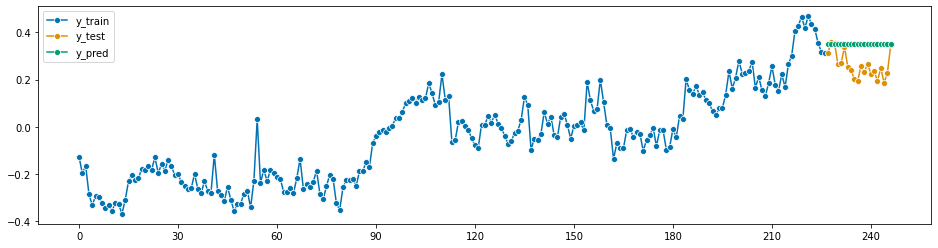

In [38]:
series_num = 15
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

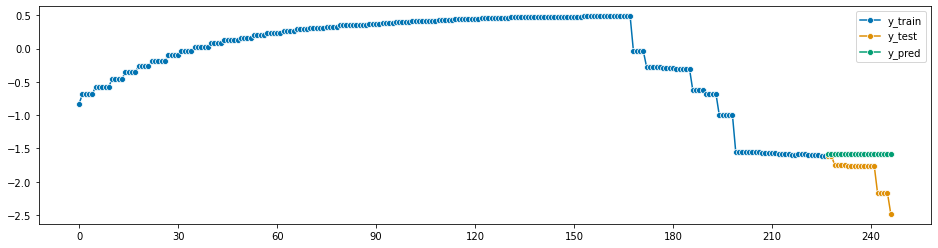

In [39]:
series_num = 16
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

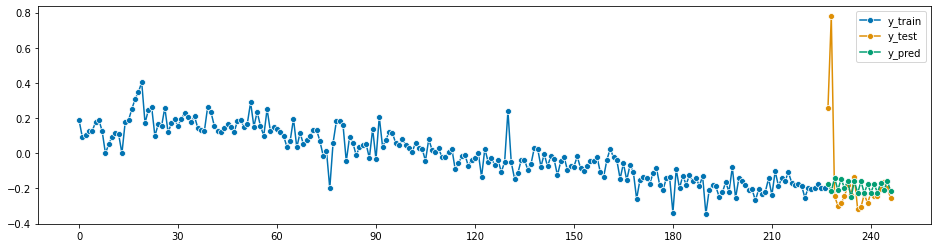

In [40]:
series_num = 18
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

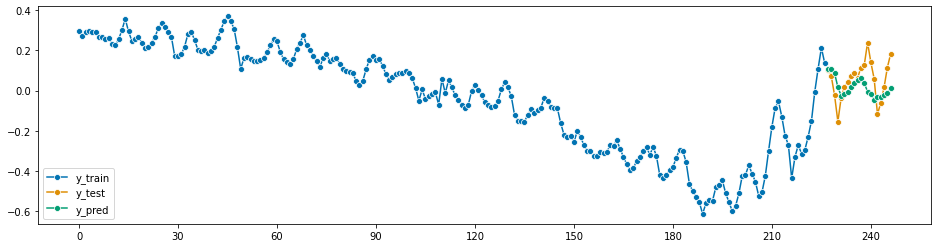

In [41]:
series_num = 19
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

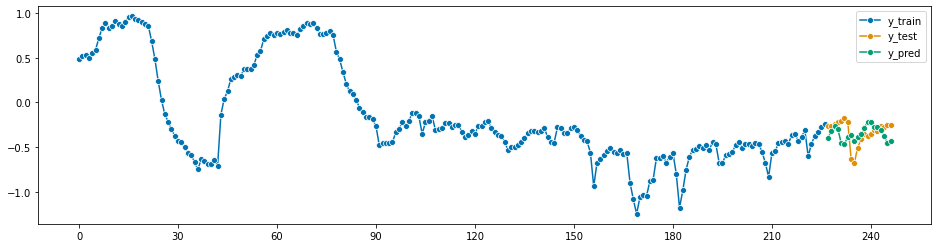

In [42]:
series_num = 140
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

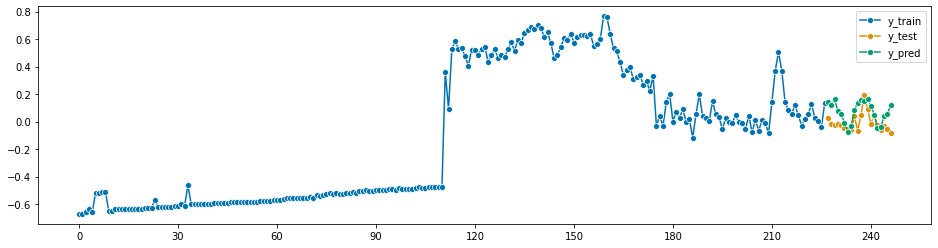

In [43]:
series_num = 163
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

***

Use 'direct' approach.

In [44]:
#### forecasting pipeline
# deseasonalize the data
# detrend the data
# ------- need to make these conditional transformations

forecaster = TransformedTargetForecaster(
    [
        #("deseasonalize", Deseasonalizer(sp=52, model="additive")),
        #("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=10, strategy="direct")),
    ]
)

In [45]:
h = 20

# empty arrays to store error metrics for each series
maes = np.zeros([num_series])
rmses = np.zeros([num_series])
# list to store forecasts
Y_preds = []

# loop over all series
for i in range(num_series):
    # select ith series
    y = Y_nested.iloc[i,0]
    
    # train-test split
    y_train, y_test = temporal_train_test_split(y, test_size=h)
    
    # store forecasts for series y
    y_preds = []

    for j in range(h):
    
        forecaster.fit(y_train, fh=j+1)
    
        y_preds.append(forecaster.predict())
    
    y_preds = pd.concat(y_preds)
    
    # store forecasts
    Y_preds.append(y_preds)
    
#     # perform post-processing
#     y_train = np.exp(y_train)*series_means[i]
#     y_test = np.exp(y_test)*series_means[i]
#     y_preds = np.exp(y_preds)*series_means[i]
    
    # store error metrics
    maes[i] = mean_absolute_error(y_test, y_preds)
    rmses[i] = mean_squared_error(y_test, y_preds, square_root=True)    

In [46]:
# average mean absolute error across series
np.mean(maes)

0.06455370431241055

In [47]:
# average root mean squared error across series
np.mean(rmses)

0.07624550255439996

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

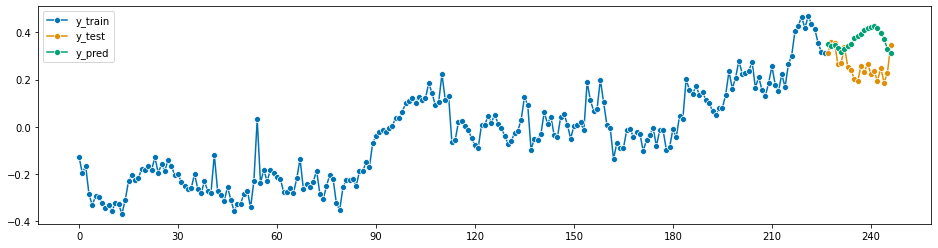

In [48]:
series_num = 15
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

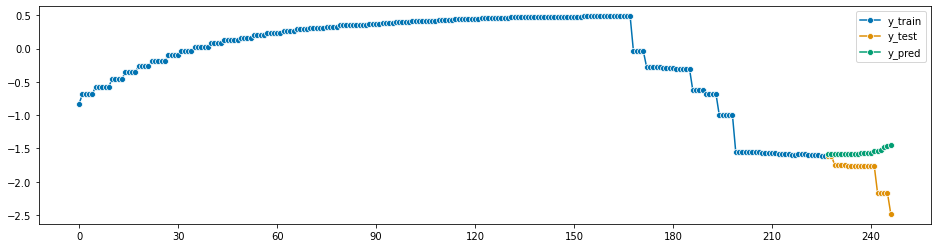

In [49]:
series_num = 16
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

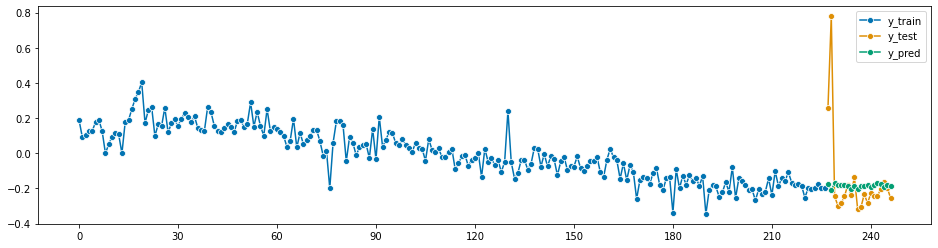

In [50]:
series_num = 18
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

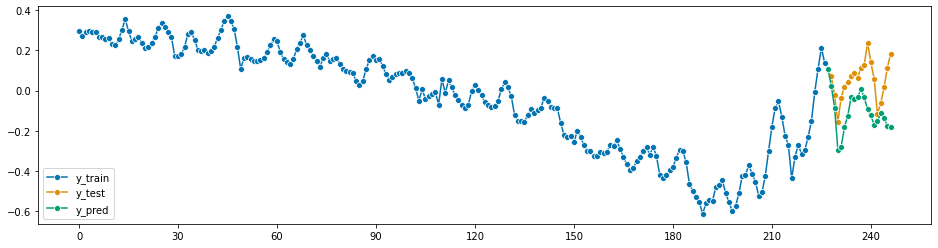

In [51]:
series_num = 19
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

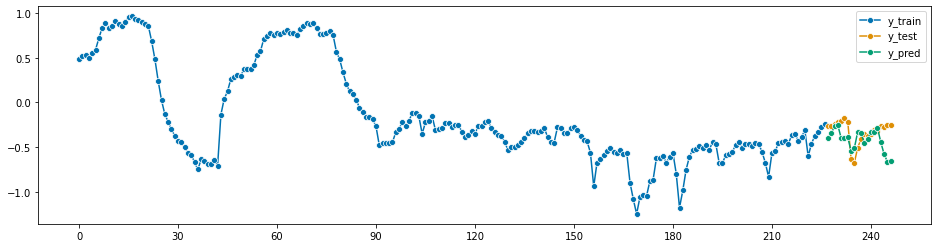

In [52]:
series_num = 140
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

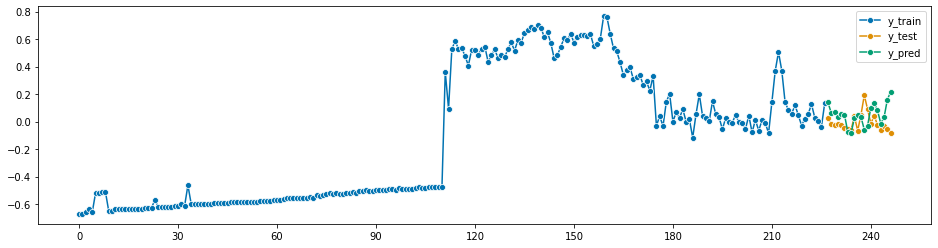

In [53]:
series_num = 163
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])